Loaded 780 rows for SPY


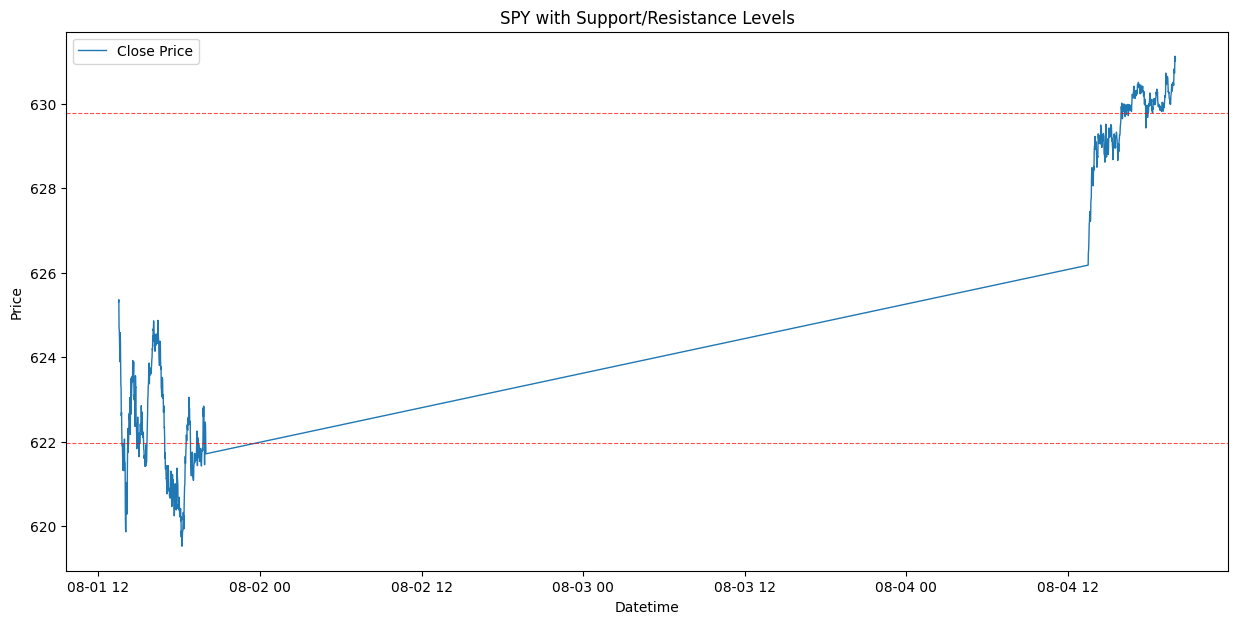

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from scipy.signal import argrelextrema
from sklearn.cluster import DBSCAN

# ---------------------------
# 1. Load data from PostgreSQL
# ---------------------------
def load_stock_data(ticker, start_date, end_date):
    db_name = "stockdata"
    db_user = "khaled"
    db_password = "Arsenal4th-"
    db_host = "localhost"
    db_port = "5432"

    engine = create_engine(
        f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
    )

    query = f"""
        SELECT datetime, open, high, low, close, volume
        FROM stock_data
        WHERE ticker = '{ticker}'
        AND datetime BETWEEN '{start_date}' AND '{end_date}'
        ORDER BY datetime;
    """
    df = pd.read_sql(query, engine)
    return df


# ---------------------------
# 2. Detect local extrema
# ---------------------------
def detect_extrema(df, order=20):
    if len(df) < order * 2:
        print("⚠️ Not enough data for extrema detection")
        return []

    df['min'] = df['low'].iloc[argrelextrema(
        df['low'].values, np.less_equal, order=order
    )[0]]
    df['max'] = df['high'].iloc[argrelextrema(
        df['high'].values, np.greater_equal, order=order
    )[0]]

    levels = pd.concat([df['min'].dropna(), df['max'].dropna()])
    return levels.values.tolist()


# ---------------------------
# 3. Cluster levels into zones
# ---------------------------
def cluster_levels(levels, eps=0.5):
    """
    Cluster price levels using DBSCAN.
    eps: price distance threshold for clustering
    """
    levels = np.array(levels).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=2).fit(levels)
    clustered_levels = {}
    for cluster_id in set(clustering.labels_):
        if cluster_id == -1:
            continue
        cluster_points = levels[clustering.labels_ == cluster_id]
        clustered_levels[cluster_id] = np.mean(cluster_points)
    return list(clustered_levels.values())


# ---------------------------
# 4. Visualization
# ---------------------------
def plot_with_levels(df, levels, ticker):
    plt.figure(figsize=(15, 7))
    plt.plot(df['datetime'], df['close'], label='Close Price', linewidth=1)

    for level in levels:
        plt.axhline(level, color='red', linestyle='--', linewidth=0.8, alpha=0.7)

    plt.title(f"{ticker} with Support/Resistance Levels")
    plt.xlabel("Datetime")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    ticker = "SPY"
    start_date = "2025-08-01"
    end_date = "2025-08-05"

    df = load_stock_data(ticker, start_date, end_date)
    print(f"Loaded {len(df)} rows for {ticker}")

    levels = detect_extrema(df, order=10)  # try smaller order
if not levels:
    print("⚠️ No levels detected, try increasing date range or lowering order.")
else:
    clustered_levels = cluster_levels(levels, eps=1.0)
    plot_with_levels(df, clustered_levels, ticker)



In [13]:
ticker = "AAPL"
start_date = "2025-09-01"
end_date = "2025-09-05"

df = load_stock_data(ticker, start_date, end_date)
df = calculate_vwap(df)

In [12]:
def calculate_vwap(df):
    """
    Adds a 'vwap' column to the DataFrame using intraday cumulative calculation.
    Assumes df has columns: ['datetime', 'open', 'high', 'low', 'close', 'volume']
    """
    df = df.copy()
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap'] = vwap
    return df


def detect_vwap_rejections(df):
    """
    Detects VWAP rejection signals in the DataFrame.
    Returns a DataFrame with signal columns: 'long_signal', 'short_signal'.
    """
    df = df.copy()
    df['prev_close'] = df['close'].shift(1)
    df['prev_vwap'] = df['vwap'].shift(1)

    # Long: prev close below vwap, current close above vwap
    df['long_signal'] = (df['prev_close'] < df['prev_vwap']) & (df['close'] > df['vwap'])
    # Short: prev close above vwap, current close below vwap
    df['short_signal'] = (df['prev_close'] > df['prev_vwap']) & (df['close'] < df['vwap'])
    return df

# Example usage:
# ticker = "AAPL"
# start_date = "2025-09-01"
# end_date = "2025-09-05"

# df = load_stock_data(ticker, start_date, end_date)
# print(f"Loaded {len(df)} rows for {ticker}")
# df = calculate_vwap(df)
# df = detect_vwap_rejections(df)
# print(df[df['long_signal'] | df['short_signal']][['datetime', 'close', 'vwap', 'long_signal', 'short_signal']])

In [14]:
def detect_vwap_rejections_with_buffer(df, buffer_pct=0.05):
    """
    Detect VWAP rejection signals with a buffer zone.
    Only signal if price moves at least buffer_pct (e.g., 0.05 = 0.05%) away from VWAP before crossing back.
    """
    df = df.copy()
    df['prev_close'] = df['close'].shift(1)
    df['prev_vwap'] = df['vwap'].shift(1)
    df['prev_dist'] = (df['prev_close'] - df['prev_vwap']) / df['prev_vwap'] * 100
    df['curr_dist'] = (df['close'] - df['vwap']) / df['vwap'] * 100

    # Long: previous close below VWAP by at least buffer, now above VWAP
    df['long_signal'] = (df['prev_dist'] < -buffer_pct) & (df['curr_dist'] > 0)
    # Short: previous close above VWAP by at least buffer, now below VWAP
    df['short_signal'] = (df['prev_dist'] > buffer_pct) & (df['curr_dist'] < 0)
    return df

# Example usage:
df = detect_vwap_rejections_with_buffer(df, buffer_pct=0.05)  # 0.05% buffer

In [6]:
def calculate_vwap_by_day(df):
    """
    Calculate VWAP for each trading day separately (session-based VWAP).
    Adds a 'vwap' column to the DataFrame.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['datetime']).dt.date
    vwap_list = []
    for date, group in df.groupby('date'):
        typical_price = (group['high'] + group['low'] + group['close']) / 3
        vwap = (typical_price * group['volume']).cumsum() / group['volume'].cumsum()
        vwap_list.append(vwap)
    df['vwap'] = pd.concat(vwap_list).sort_index()
    df.drop('date', axis=1, inplace=True)
    return df

# Example usage:
# df = calculate_vwap_by_day(df)

In [7]:
# --- Use session-based VWAP calculation and detect signals ---
ticker = "AAPL"
start_date = "2025-09-01"
end_date = "2025-09-05"

df = load_stock_data(ticker, start_date, end_date)
print(f"Loaded {len(df)} rows for {ticker}")
df = calculate_vwap_by_day(df)
df = detect_vwap_rejections(df)

# Show detected signals
display_cols = ['datetime', 'close', 'vwap', 'long_signal', 'short_signal']
print(df[df['long_signal'] | df['short_signal']][display_cols])

Loaded 1170 rows for AAPL
                      datetime   close        vwap  long_signal  short_signal
6    2025-09-02 13:36:00+00:00  229.22  228.601237         True         False
72   2025-09-02 14:42:00+00:00  229.41  229.524585        False          True
244  2025-09-02 17:34:00+00:00  228.81  228.787549         True         False
266  2025-09-02 17:56:00+00:00  228.76  228.795523        False          True
321  2025-09-02 18:51:00+00:00  228.89  228.775830         True         False
322  2025-09-02 18:52:00+00:00  228.70  228.775809        False          True
330  2025-09-02 19:00:00+00:00  228.81  228.774269         True         False
333  2025-09-02 19:03:00+00:00  228.20  228.758452        False          True
342  2025-09-02 19:12:00+00:00  228.87  228.753865         True         False
390  2025-09-03 13:30:00+00:00  236.83  237.183333        False          True
411  2025-09-03 13:51:00+00:00  236.02  235.995616         True         False
412  2025-09-03 13:52:00+00:00  235.85

## VWAP Rejection Strategy: Implementation Steps

We will start with a simple VWAP rejection strategy, without any trend filter:

- **VWAP Calculation:** For each bar, VWAP = cumulative sum of (price × volume) / cumulative sum of volume, using intraday data.
- **Rejection Setup:**
    - A long signal occurs when price crosses below VWAP and then closes back above it (rejection from below).
    - A short signal occurs when price crosses above VWAP and then closes back below it (rejection from above).
- No trend or session filter is applied for now.

Let's implement VWAP calculation and signal detection.

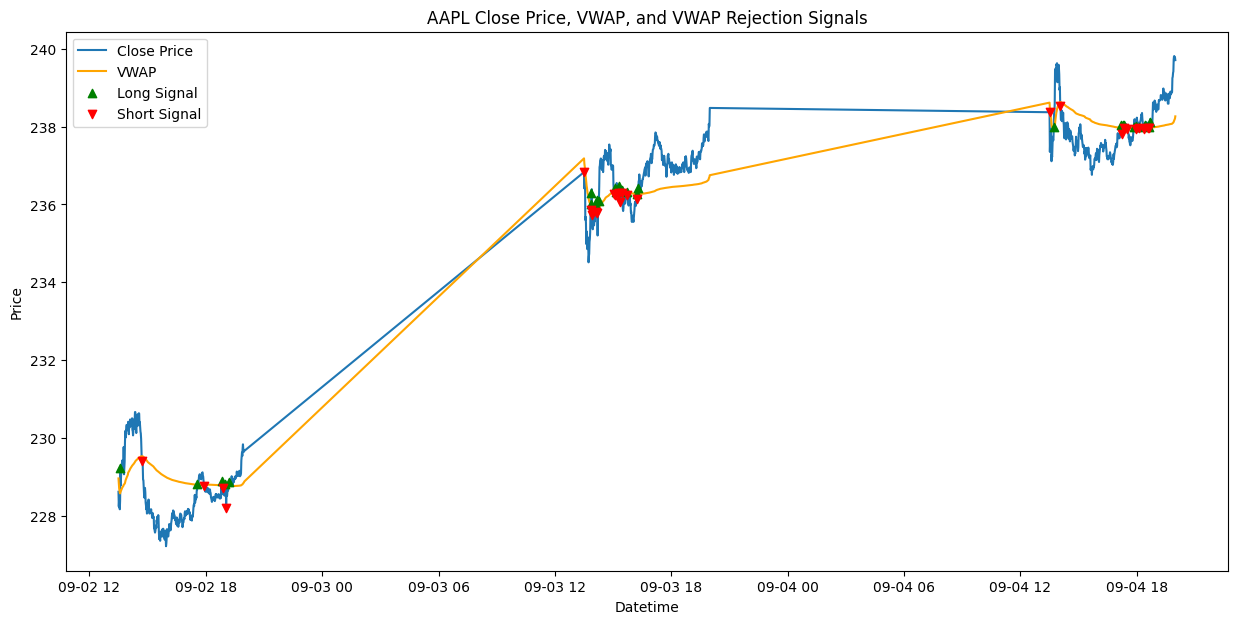

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.plot(df['datetime'], df['vwap'], label='VWAP', color='orange')

# Plot signals
plt.scatter(df.loc[df['long_signal'], 'datetime'], df.loc[df['long_signal'], 'close'], marker='^', color='green', label='Long Signal', zorder=5)
plt.scatter(df.loc[df['short_signal'], 'datetime'], df.loc[df['short_signal'], 'close'], marker='v', color='red', label='Short Signal', zorder=5)

plt.legend()
plt.title('AAPL Close Price, VWAP, and VWAP Rejection Signals')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.show()

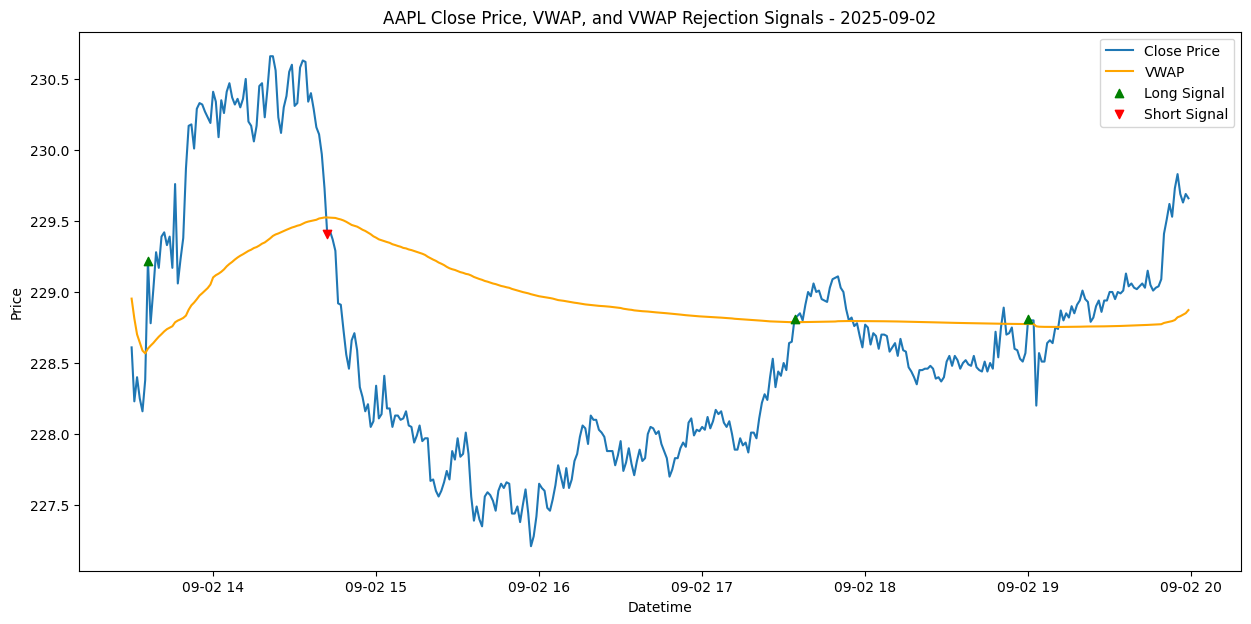

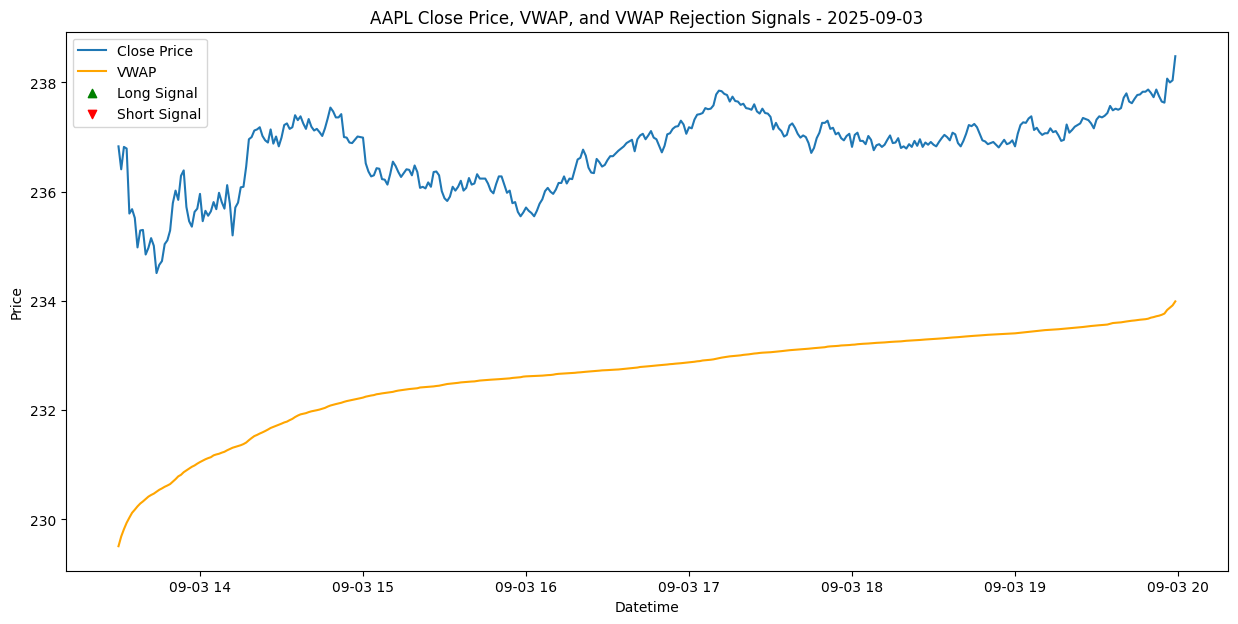

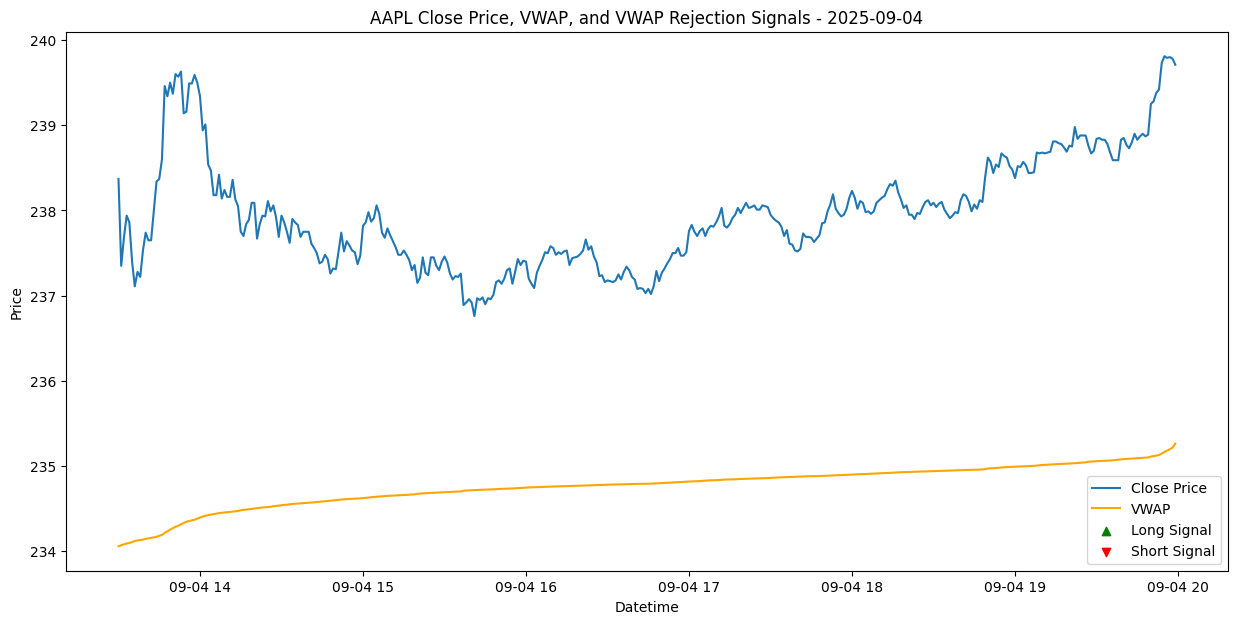

In [15]:
# --- Plot VWAP and signals for each day separately ---
df['date'] = pd.to_datetime(df['datetime']).dt.date
for date, group in df.groupby('date'):
    plt.figure(figsize=(15, 7))
    plt.plot(group['datetime'], group['close'], label='Close Price')
    plt.plot(group['datetime'], group['vwap'], label='VWAP', color='orange')
    # Plot signals
    plt.scatter(group.loc[group['long_signal'], 'datetime'], group.loc[group['long_signal'], 'close'], marker='^', color='green', label='Long Signal', zorder=5)
    plt.scatter(group.loc[group['short_signal'], 'datetime'], group.loc[group['short_signal'], 'close'], marker='v', color='red', label='Short Signal', zorder=5)
    plt.legend()
    plt.title(f'AAPL Close Price, VWAP, and VWAP Rejection Signals - {date}')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.show()
del df['date']  # Clean up temporary column

In [19]:
df

,open,high,low,close,volume,vwap,prev_close,prev_vwap,prev_dist,curr_dist,long_signal,short_signal
datetime,,,,,,,,,,,,
2025-09-02 13:30:00+00:00,229.25,229.70,228.55,228.61,1041741,228.953333,NaN,NaN,NaN,-0.149958,False,False
2025-09-02 13:31:00+00:00,228.64,228.79,227.90,228.23,286696,228.813773,228.61,228.953333,-0.149958,-0.255130,False,False
2025-09-02 13:32:00+00:00,228.24,228.50,227.68,228.40,293350,228.701548,228.23,228.813773,-0.255130,-0.131852,False,False
2025-09-02 13:33:00+00:00,228.36,228.49,228.06,228.25,250331,228.643397,228.40,228.701548,-0.131852,-0.172057,False,False
2025-09-02 13:34:00+00:00,228.25,228.49,227.89,228.16,256197,228.587616,228.25,228.643397,-0.172057,-0.187069,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-04 19:55:00+00:00,239.74,239.82,239.65,239.81,404339,235.167723,239.73,235.146961,1.949011,1.974028,False,False
2025-09-04 19:56:00+00:00,239.82,239.85,239.76,239.79,284765,235.182360,239.81,235.167723,1.974028,1.959178,False,False
2025-09-04 19:57:00+00:00,239.79,239.85,239.67,239.80,320601,235.198634,239.79,235.182360,1.959178,1.956375,False,False


In [23]:
ticker = "AAPL"
start_date = "2025-01-01"
end_date = "2025-09-08"

df = load_stock_data(ticker, start_date, end_date)
df = calculate_vwap(df)

In [17]:
def moving_average_crossover_signals(df, st_sma=10, lt_sma=50):
    """
    Add short-term and long-term SMA columns and generate crossover signals.
    Returns a DataFrame with 'sma_short', 'sma_long', 'long_signal', 'short_signal'.
    """
    df = df.copy()
    df['sma_short'] = df['close'].rolling(st_sma).mean()
    df['sma_long'] = df['close'].rolling(lt_sma).mean()
    df['prev_sma_short'] = df['sma_short'].shift(1)
    df['prev_sma_long'] = df['sma_long'].shift(1)
    # Long: short SMA crosses above long SMA
    df['long_signal'] = (df['prev_sma_short'] < df['prev_sma_long']) & (df['sma_short'] > df['sma_long'])
    # Short: short SMA crosses below long SMA
    df['short_signal'] = (df['prev_sma_short'] > df['prev_sma_long']) & (df['sma_short'] < df['sma_long'])
    return df


In [24]:
# --- Resample 1-min data to daily OHLCV and apply MA crossover ---
# Assumes df is loaded with 1-min bars and has columns: datetime, open, high, low, close, volume
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
daily = df.resample('1D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna().reset_index()

# Apply parameterized MA crossover on daily bars
st_sma = 10  # short-term SMA period
lt_sma = 50  # long-term SMA period
daily_ma = moving_average_crossover_signals(daily, st_sma=st_sma, lt_sma=lt_sma)

# Show signals
display_cols = ['datetime', 'close', 'sma_short', 'sma_long', 'long_signal', 'short_signal']
print(daily_ma[daily_ma['long_signal'] | daily_ma['short_signal']][display_cols])

                     datetime   close  sma_short  sma_long  long_signal   
95  2025-05-21 00:00:00+00:00  202.05    207.239  207.0538         True  \
99  2025-05-28 00:00:00+00:00  200.42    205.009  205.9168        False   
124 2025-07-03 00:00:00+00:00  213.59    204.539  203.6924         True   

     short_signal  
95          False  
99           True  
124         False  


In [22]:
daily

,datetime,open,high,low,close,volume
0,2025-09-02 00:00:00+00:00,229.25,230.85,226.97,229.66,22560705
1,2025-09-03 00:00:00+00:00,237.21,238.85,234.36,238.48,41876214
2,2025-09-04 00:00:00+00:00,238.45,239.90,236.74,239.71,27325798
